## Домашнее задание:

1. Обучите CNN (самописная) на CIFAR-100.
2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.

In [47]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
from torchsummary import summary
from torchvision import models

**1. Обучите CNN (самописная) на CIFAR-100.**

In [61]:
class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.25, random_state=13)
    return X_train, X_test

In [62]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

Files already downloaded and verified


In [63]:
trans_actions = transforms.Compose([transforms.ToTensor()])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

In [64]:
BATCH_SIZE = 128

In [65]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=1)

In [66]:
print(f'Number of train batches: {len(train_loader)}')
print(f'Number of test batches: {len(valid_loader)}')

Number of train batches: 293
Number of test batches: 98


In [67]:
classes = pickle.load(open('./data/cifar-100-python/meta', 'rb'))
classes = classes['fine_label_names']

print(classes[:10])
print(f'Number of classes: {len(classes)}')

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']
Number of classes: 100


torch.Size([128, 3, 32, 32])
fox


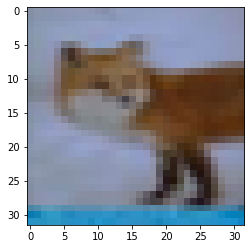

In [68]:
for img, lbl in train_loader:
    print(img.shape)
    print(classes[lbl[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [69]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [70]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()     
                
        self.bn1 = torch.nn.BatchNorm2d(3) 
        self.conv1 = torch.nn.Conv2d(3, 30, 3)

        self.bn2 = torch.nn.BatchNorm2d(30) 
        self.conv2 = torch.nn.Conv2d(30, 60, 3)

        self.bn3 = torch.nn.BatchNorm2d(60)

        self.fc1 = torch.nn.Linear(960, 200)
        self.dp1 = nn.Dropout(0.2)

        self.fc2 = torch.nn.Linear(200, 60)
        self.dp2 = nn.Dropout(0.2)

        self.out = torch.nn.Linear(60, 100)
        
    def forward(self, x):
        x = self.bn1(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3)
        
        x = self.bn2(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn3(x)
        x = x.view(x.size(0), -1)
        x = self.dp1(x)

        x = self.fc1(x)
        x = F.relu(x)        
        x = self.dp2(x)

        x = self.fc2(x)
        x = F.relu(x)

        return self.out(x)


net = Net().to(device)
print(net)

Net(
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=960, out_features=200, bias=True)
  (dp1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=200, out_features=60, bias=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=60, out_features=100, bias=True)
)


In [71]:
summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 30, 30, 30]             840
       BatchNorm2d-3           [-1, 30, 10, 10]              60
            Conv2d-4             [-1, 60, 8, 8]          16,260
       BatchNorm2d-5             [-1, 60, 4, 4]             120
           Dropout-6                  [-1, 960]               0
            Linear-7                  [-1, 200]         192,200
           Dropout-8                  [-1, 200]               0
            Linear-9                   [-1, 60]          12,060
           Linear-10                  [-1, 100]           6,100
Total params: 227,646
Trainable params: 227,646
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.30
Params size (MB): 0.87
Estimated T

In [72]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [73]:
num_epochs = 10
net.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        if i % 300 == 0:   
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
       
        net.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/293]. Loss: 0.036. Acc: 0.023. Test acc: 0.011
Epoch [2/10]. Step [1/293]. Loss: 0.030. Acc: 0.086. Test acc: 0.131
Epoch [3/10]. Step [1/293]. Loss: 0.027. Acc: 0.148. Test acc: 0.187
Epoch [4/10]. Step [1/293]. Loss: 0.025. Acc: 0.203. Test acc: 0.227
Epoch [5/10]. Step [1/293]. Loss: 0.021. Acc: 0.328. Test acc: 0.245
Epoch [6/10]. Step [1/293]. Loss: 0.023. Acc: 0.266. Test acc: 0.281
Epoch [7/10]. Step [1/293]. Loss: 0.020. Acc: 0.305. Test acc: 0.291
Epoch [8/10]. Step [1/293]. Loss: 0.021. Acc: 0.281. Test acc: 0.306
Epoch [9/10]. Step [1/293]. Loss: 0.020. Acc: 0.352. Test acc: 0.305
Epoch [10/10]. Step [1/293]. Loss: 0.021. Acc: 0.305. Test acc: 0.321
Training is finished!


**2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.**

In [74]:
resnet50 = models.resnet50(pretrained=True)
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [75]:
for param in list(resnet50.parameters())[:]:
    param.requires_grad = False

In [76]:
resnet50.fc = nn.Linear(2048, 100)
summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [77]:
resnet50 = resnet50.to(device)

In [78]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [79]:
num_epochs = 10
resnet50.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        if i % 300 == 0: 
            resnet50.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = resnet50(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet50.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/293]. Loss: 0.037. Acc: 0.023. Test acc: 0.010
Epoch [2/10]. Step [1/293]. Loss: 0.023. Acc: 0.328. Test acc: 0.246
Epoch [3/10]. Step [1/293]. Loss: 0.021. Acc: 0.305. Test acc: 0.272
Epoch [4/10]. Step [1/293]. Loss: 0.021. Acc: 0.336. Test acc: 0.271
Epoch [5/10]. Step [1/293]. Loss: 0.021. Acc: 0.320. Test acc: 0.288
Epoch [6/10]. Step [1/293]. Loss: 0.017. Acc: 0.414. Test acc: 0.286
Epoch [7/10]. Step [1/293]. Loss: 0.017. Acc: 0.453. Test acc: 0.287
Epoch [8/10]. Step [1/293]. Loss: 0.018. Acc: 0.406. Test acc: 0.291
Epoch [9/10]. Step [1/293]. Loss: 0.018. Acc: 0.398. Test acc: 0.294
Epoch [10/10]. Step [1/293]. Loss: 0.016. Acc: 0.539. Test acc: 0.296
Training is finished!
